## Python Setup

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

Fetch the dataset from OpenML

In [13]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

## Preprocessing

Define the features we want to use, noting that 'survived' is the target and shouldn't be in features

In [18]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
X = X[features]

Add a 'FamilySize' feature

In [21]:
X['familysize'] = X['sibsp'] + X['parch'] + 1

Define numerical and categorical features

In [24]:
numerical_features = ['age', 'fare', 'familysize']
categorical_features = ['pclass', 'sex', 'embarked']

## Create preprocessing pipelines

In [27]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

## Combine preprocessing steps

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Create the model pipeline

In [35]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

## Split the data
Note: y needs to be encoded to numerical before splitting if it's not already numerical

In [42]:
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model

In [45]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare',
                                                   'familysize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Predict probabilities

In [57]:
probabilities = model_pipeline.predict_proba(X_test)[:, 1]

## Calculate AUC

In [59]:
roc_auc_score(y_test, probabilities)

0.8598752354048964

## Calculate ROC curve

In [64]:
fpr, tpr, _ = roc_curve(y_test, probabilities)

## Plot ROC curve

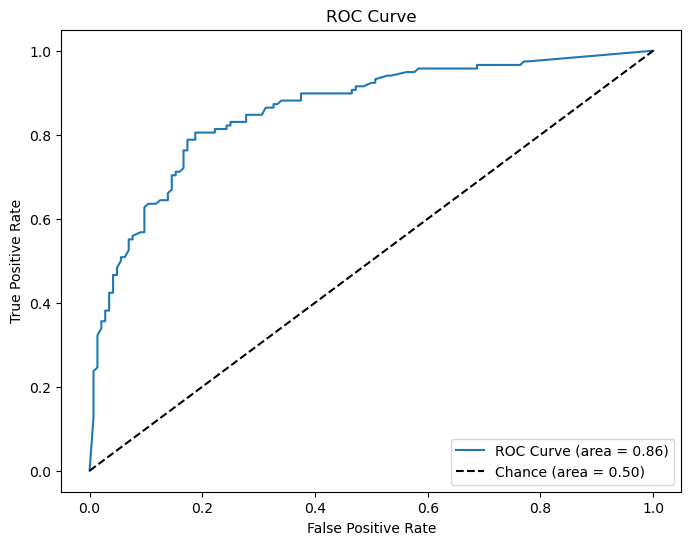

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (area = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()